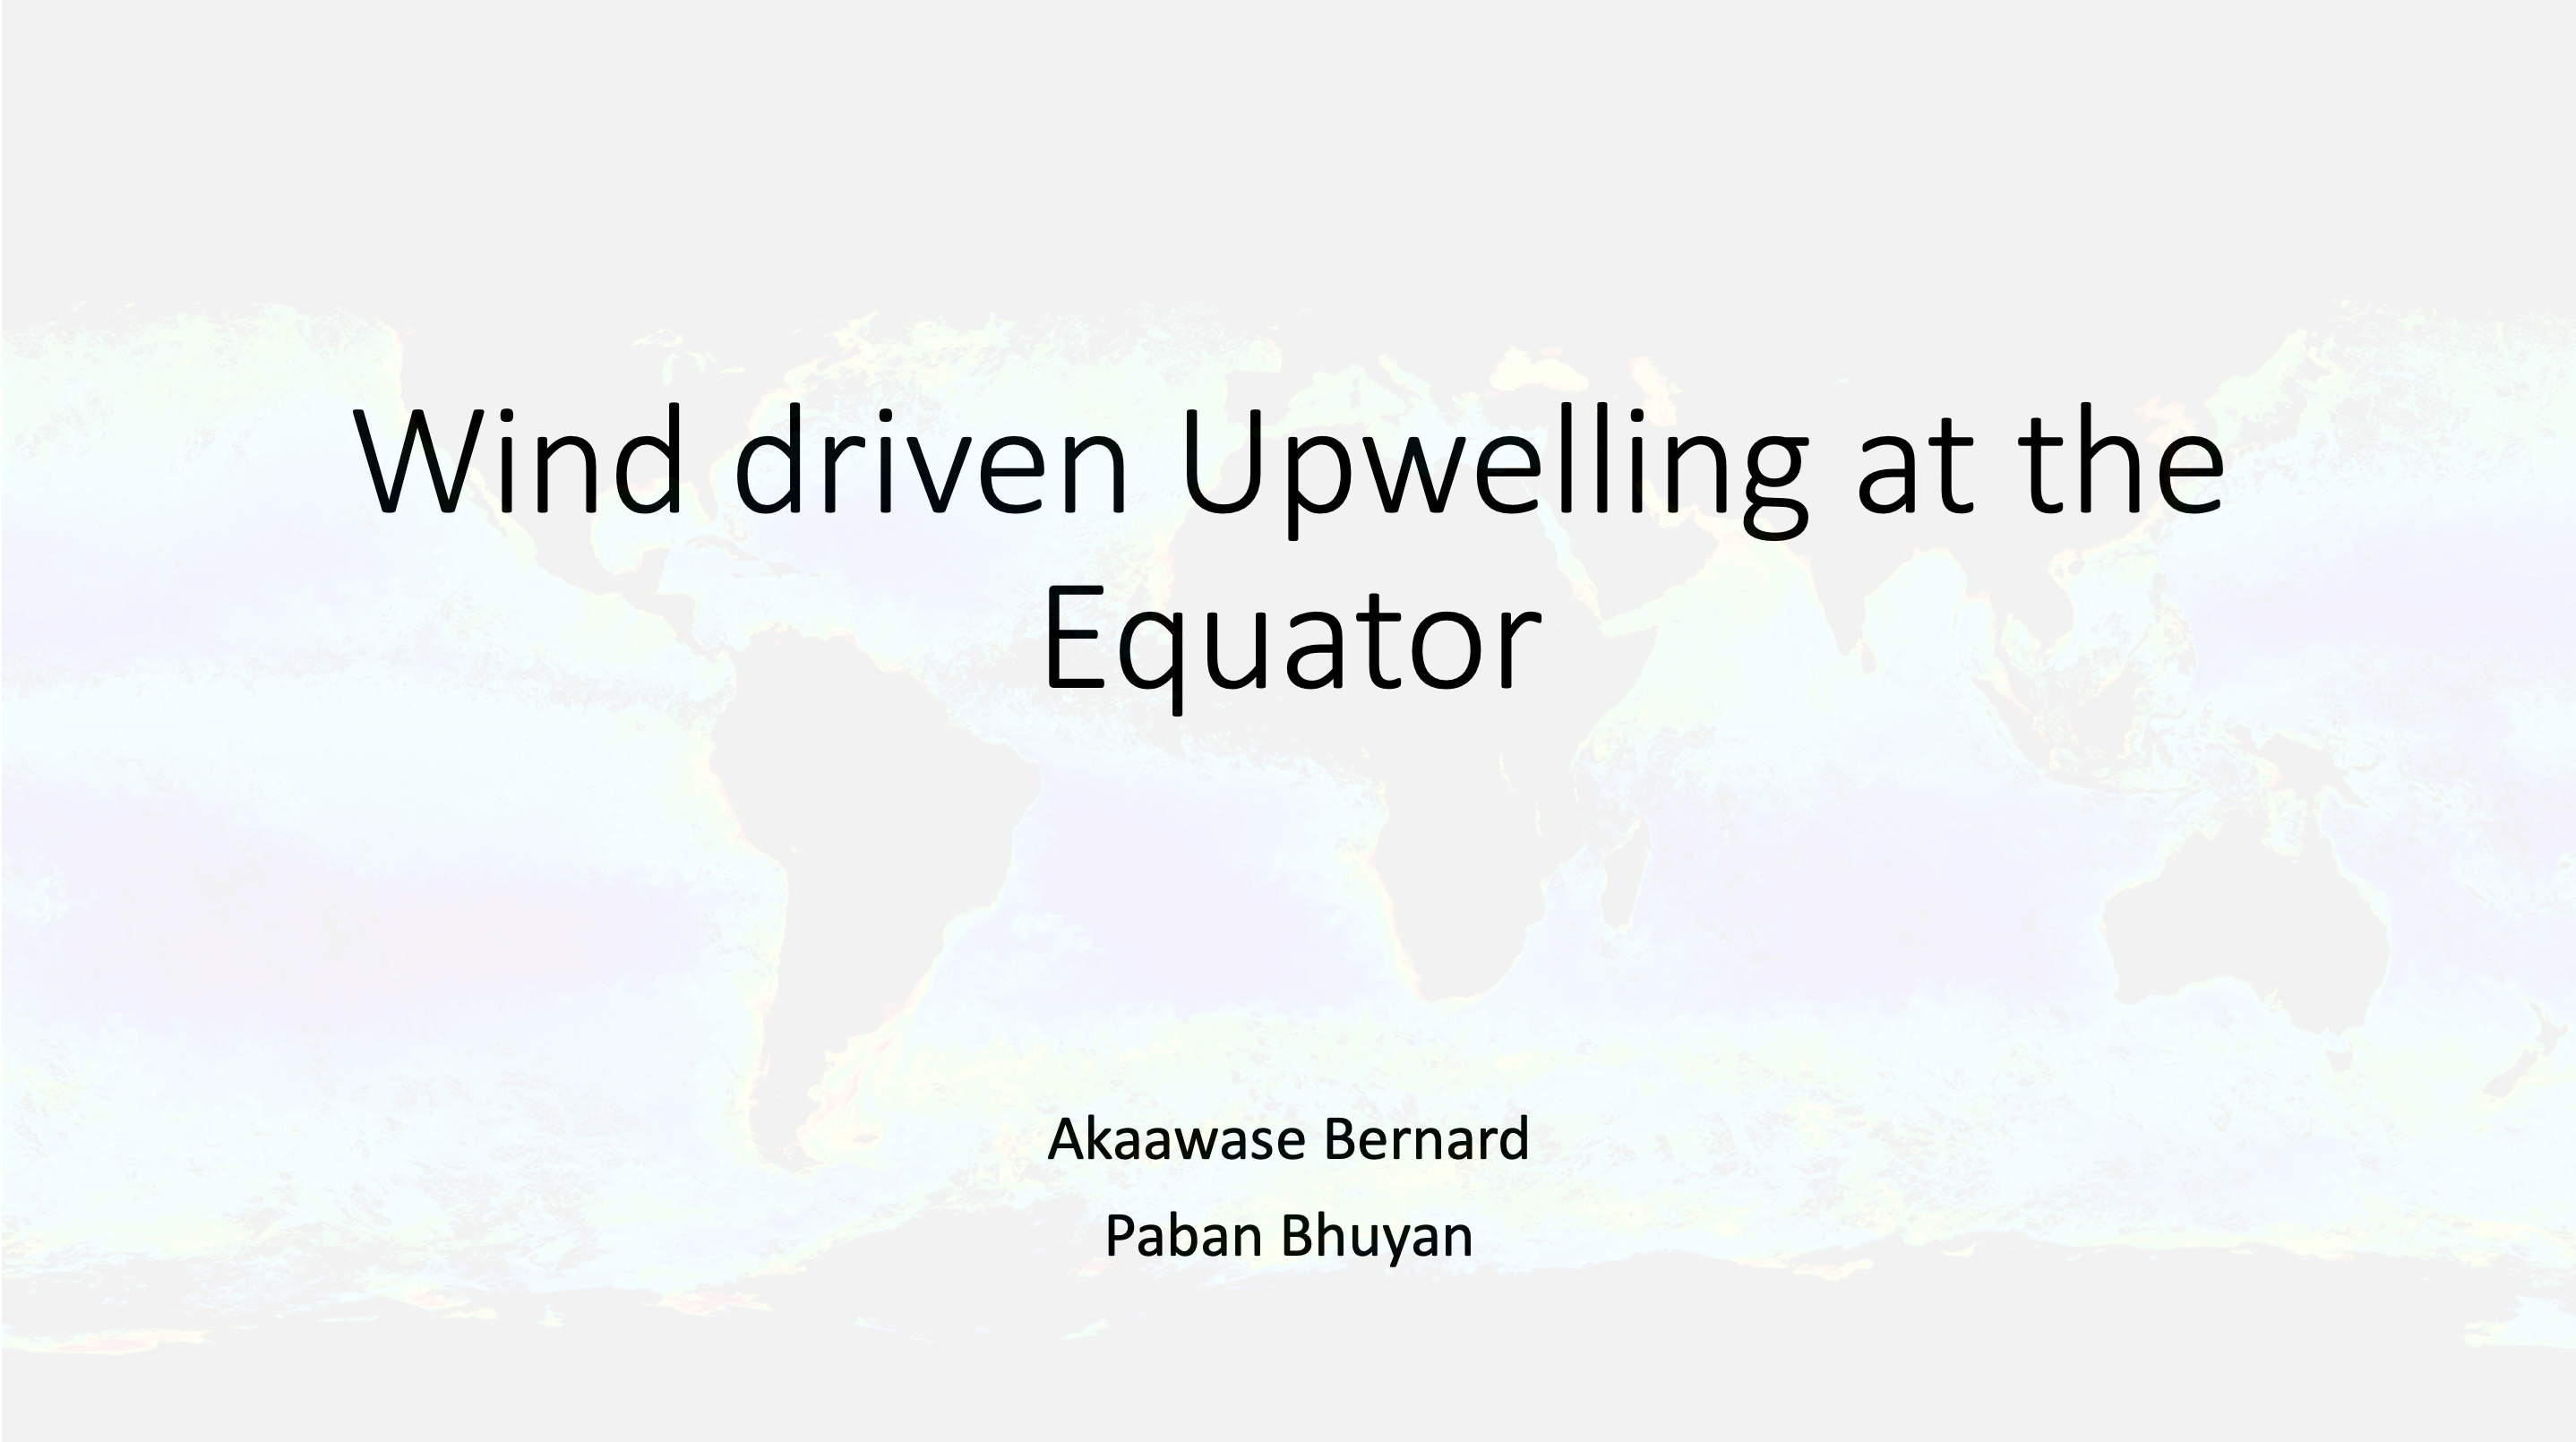

### Load modules

In [1]:
#Import Relevant Packages
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy
from matplotlib import ticker,cm 
import cmocean as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

### Loading the data using xarray

In [3]:
# Path to dataset
DATA_ROOT = '/shared/marn5895/data/Bernard_Paban_Project/Data/'

In [40]:
#You can access the data from the shared folder
u = xr.open_dataset(DATA_ROOT + 'OSCAR_zonal_current_2015.nc') 
v = xr.open_dataset(DATA_ROOT + 'OSCAR_meridional_current_2015.nc')

current = xr.merge([u,v])
wind = xr.open_dataset(DATA_ROOT + 'ERA5_wind.nc')
chl = xr.load_dataset(DATA_ROOT + 'dataset-oc-glo-bio-multi-l4-chl_4km_monthly-rep_1637967441442.nc')
ssh = xr.open_dataset(DATA_ROOT + 'dataset-duacs-rep-global-merged-allsat-phy-l4-monthly_1637960787662.nc')

## Making data CF-compliant

In [41]:
def make_cf_compliant(ds):
    
    
    '''
    This function converts the non-CF compliant coordinates such as longitude, latitude, and time to CF 1.9  compliant corrdinates.
    '''
    
    
    non_cf_lons = ['LON1_1021',  'lon']
    non_cf_lats = ['LAT','lat']
    non_cf_time = ['TIME']
    non_cf_lev = ['LEV']

    cf_names = ['longitude', 'latitude', 'time','lev']
    non_cf_vars = [non_cf_lons, non_cf_lats, non_cf_time, non_cf_lev]
    

    # first check for every variable names
    for n in range(len(cf_names)): 
        
        # if variable is non-cf comliant then convert the variable to cf-comliant  
        
        if any(var in ds.coords for var in non_cf_vars[n]):
            #print('%s : was non-CF compliant'%cf_names[n])
            for i in non_cf_vars[n]:
                if i in ds.coords:
                    ds = ds.rename(({'%s'%i:'%s'%cf_names[n]}))

#         else:
            
#             print('%s : CF Compliant'%cf_names[n])
         
    return ds

In [42]:
chl = make_cf_compliant(chl)

wind = make_cf_compliant(wind)
current = make_cf_compliant(current)
ssh = make_cf_compliant(ssh)


### Resampling, changing coordinates, and interpolating where required

In [43]:
#chlorophyll
chl.coords['longitude'] = (chl.coords['longitude'] + 360) % 360
chl= chl.sortby(chl.longitude)
chl=chl.sel(longitude=slice(140,260),
            latitude=slice(30,-30)).resample(time='1Q').mean(dim='time').sel(time='2015')

# Surface currents  15m average
current = current.sel(longitude=slice(140,280),
                      latitude=slice(-30,30),
                      lev=15.).resample(time='1Q').mean(dim='time').sel(time='2015')


#sea surface height 
ssh = ssh.sel(longitude=slice(140,260),
              latitude=slice(-30,30)).resample(time='1Q').mean(dim='time').sel(time='2015')

# wind
wind = wind.resample(time='1Q').mean(dim='time').sel(time='2015')
wind = wind.interp(longitude=current.longitude,latitude=current.latitude)

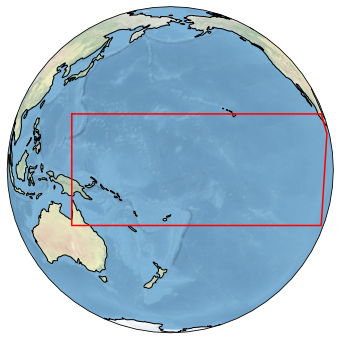

In [44]:
#Study area

plt.figure(figsize=(12, 6))
proj = ccrs.Orthographic(
    central_longitude=-180,
    central_latitude=0
)
regional_area = {
    'lon': [140,140,260,260,140],
    'lat': [20, -20,-20,20,20]
}
ax = plt.axes(projection=proj)

ax.stock_img()
ax.coastlines()

ax.plot(regional_area['lon'],
        regional_area['lat'],
        transform=ccrs.PlateCarree(),
        color='r')

In [92]:
## Variables for plotting
# lonmin = current.longitude.min()
# lonmax = current.longitude.max()
# latmin = current.latitude.min()
# latmax = current.latitude.max()

# regional_extent = [lonmin+2, lonmax-2, latmin+15, latmax-15]

#creating regional boundaries
lonmin = ssh.longitude.min()
lonmax = ssh.longitude.max()
latmin = ssh.latitude.min()
latmax = ssh.latitude.max()

regional_extent = [lonmin+2, lonmax-2, latmin+15, latmax-15]

In [316]:
div_wind  = divergence(wind)*3600*24

## Coarsening the data to 10degree resolution

In [45]:
u_1deg = current.U.coarsen(latitude=30,longitude=30,boundary='trim').mean()
v_1deg = current.V.coarsen(latitude=30,longitude=30,boundary='trim').mean()
wind_u_1deg = wind.u.coarsen(latitude=30,longitude=30,boundary='trim').mean()
wind_v_1deg = wind.v.coarsen(latitude=30,longitude=30,boundary='trim').mean()


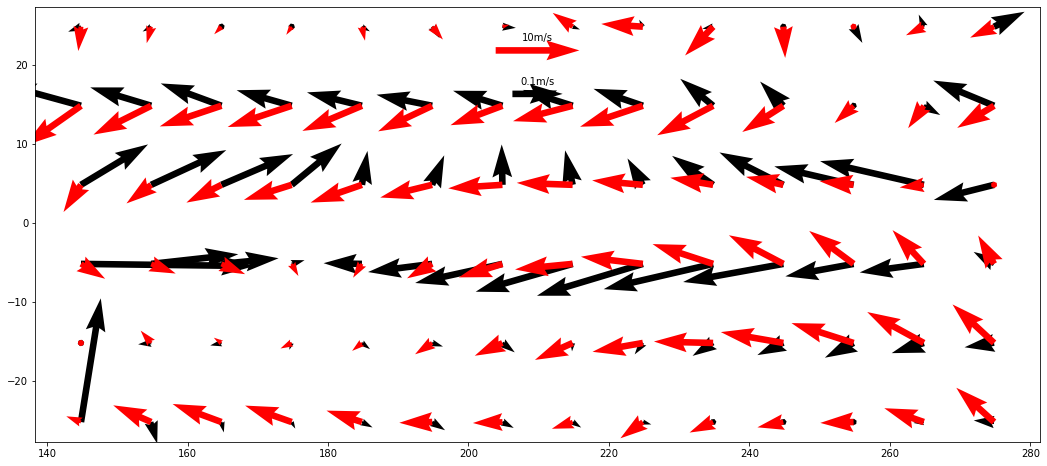

In [320]:
plt.figure(figsize=(18,8))
#ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))


skip=1
lon_skipped =  u_1deg.longitude[::skip]
lat_skipped = u_1deg.latitude[::skip]
kw_vec = {
    'scale': 2
}

u_vel= u_1deg.isel(time=0).sel(longitude=lon_skipped,latitude =lat_skipped).values
v_vel = v_1deg.isel(time=0).sel(longitude=lon_skipped,latitude =lat_skipped).values
q_c = plt.quiver(lon_skipped, 
           lat_skipped,
           u_vel,v_vel,
           **kw_vec)

plt.quiverkey(q_c, 0.5,0.8,0.1,label='0.1m/s')


skip1=1
lon_wind_skipped =  wind_u_1deg.longitude[::skip1]
lat_wind_skipped = wind_u_1deg.latitude[::skip1]
wind_u_vel= wind_u_1deg.isel(time=0).sel(longitude=lon_wind_skipped,latitude =lat_wind_skipped).values
wind_v_vel = wind_v_1deg.isel(time=0).sel(longitude=lon_wind_skipped,latitude =lat_wind_skipped).values


kw_vec = {
    'scale': 120
}


q_w = plt.quiver(lon_wind_skipped, 
           lat_wind_skipped,
           wind_u_vel,
           wind_v_vel,**kw_vec,color='r')
plt.quiverkey(q_w, 0.5,0.9,10,label='10m/s')


In [32]:
current.V

<xarray.DataArray 'V' (time: 73, lev: 1, latitude: 481, longitude: 1021)>
[35850373 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float64 20.0 20.33 20.67 21.0 ... 359.3 359.7 360.0
  * latitude   (latitude) float64 -80.0 -79.67 -79.33 -79.0 ... 79.33 79.67 80.0
  * lev        (lev) float64 15.0
  * time       (time) datetime64[ns] 2015-01-01 ... 2016-01-01
Attributes:
    long_name:  ocean surface meridional currents (m/s)
    history:    From one_third_deg_v2009.f

In [49]:
lat_diff = 111000
dvdy = current.V.diff(dim='latitude')/(lat_diff*-np.diff(current.latitude)[0])
dudx = current.U.diff(dim='longitude')/((lat_diff*-np.diff(current.latitude)[0])*np.cos(current.latitude*(np.pi/180)))

# du = xr.DataArray(np.diff(u.isel(time=0)))
# dv = xr.DataArray(np.diff(v.isel(time=0)))
# dx = xr.DataArray(np.diff(u.longitude))
# dy = xr.DataArray(np.diff(v.latitude))
# dudx = du/dx
# dvdy = dv/dy


div = dudx + dvdy
div = div*3600*24

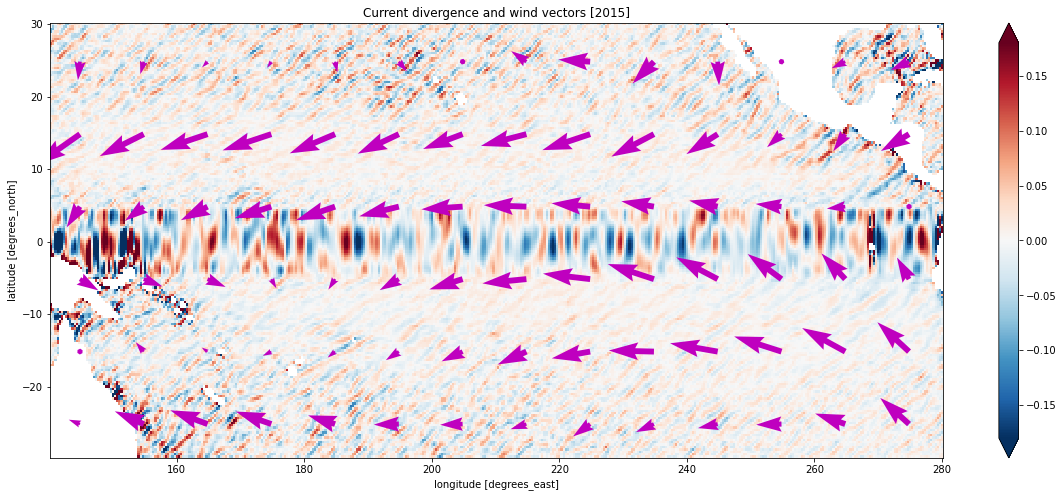

In [85]:
plt.figure(figsize=(20,8))
div.isel(time=0).plot(vmax=0.18,)
plt.title('Current divergence and wind vectors [2015]')

#skip1=0
lon_wind_skipped =  wind_u_1deg.longitude#[::skip1]
lat_wind_skipped = wind_u_1deg.latitude#[::skip1]
kw_vec = {
    'scale': 140
}

plt.quiver(wind_u_1deg.longitude, 
           wind_u_1deg.latitude,
           wind_u_1deg.isel(time=0).sel(longitude=lon_wind_skipped,latitude =lat_wind_skipped),
           wind_v_1deg.isel(time=0).sel(longitude=lon_wind_skipped,latitude =lat_wind_skipped),**kw_vec, color ='m')

## Time Series

In [96]:
#wind.u.mean(dim=['longitude','latitude']).plot()
#wind.v.mean(dim=['longitude','latitude']).plot()
#u.mean(dim=['longitude','latitude']).plot()
#v.mean(dim=['longitude','latitude']).plot()

In [87]:
chl_log10 = np.log10(chl.CHL.isel(time=0).values)

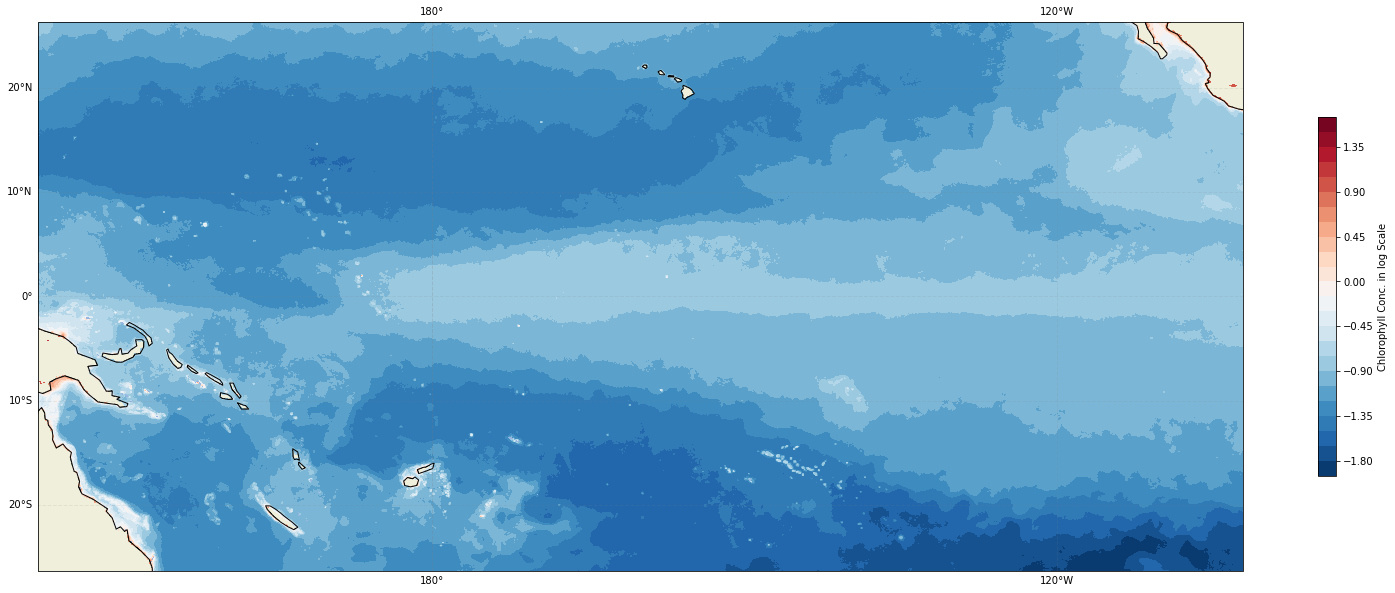

In [96]:
#creating regional boundaries

plt.figure(figsize=(27,12))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines()
ax.set_extent(regional_extent)
# Add basic features
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
#ax.add_feature(cartopy.feature.LAKES, edgecolor='black')

ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
             linewidth=1, color='gray', alpha=0.12, linestyle='--')

cm = ax.contourf(chl.longitude, chl.latitude,chl_log10,30,cmap='RdBu_r',transform=ccrs.PlateCarree())
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
plt.colorbar(cm,shrink=0.55,label='Chlorophyll Conc. in log Scale')

In [ ]:

#chl = chl.resample(time='1M').mean(dim='time').sel(time='2015')

AttributeError: 'DataArray' object has no attribute 'LON1_1021'

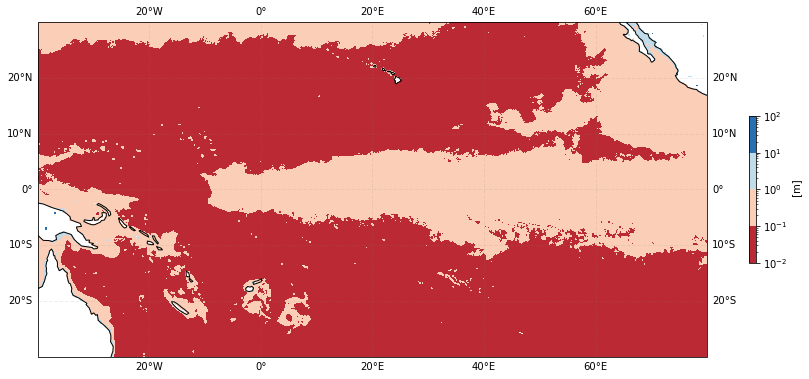

<Figure size 1080x576 with 0 Axes>

In [ ]:
#windspeed = np.sqrt(wind.u10**2 + wind.v10**2)
#windspeed = windspeed.sel(longitude=slice(140,260),latitude=slice(30,-30))
#windspeed = windspeed.resample(time='1M').mean(dim='time').sel(time='2015')


### Sea Level Anomalies and current direction

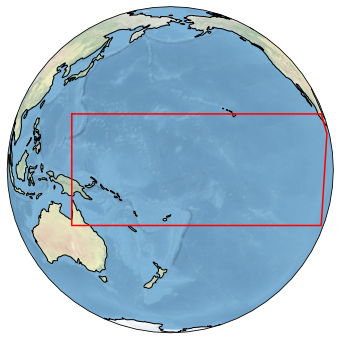

In [198]:

plt.figure(figsize=(12, 6))
proj = ccrs.Orthographic(
    central_longitude=-180,
    central_latitude=0
)
regional_area = {
    'lon': [140,140,260,260,140],
    'lat': [20, -20,-20,20,20]
}
ax = plt.axes(projection=proj)

ax.stock_img()
ax.coastlines()

ax.plot(regional_area['lon'],
        regional_area['lat'],
        transform=ccrs.PlateCarree(),
        color='r')

/home/bta21002/miniconda/envs/marn5895/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1586: UserWarning: The following kwargs were not used by contour: 'level', 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


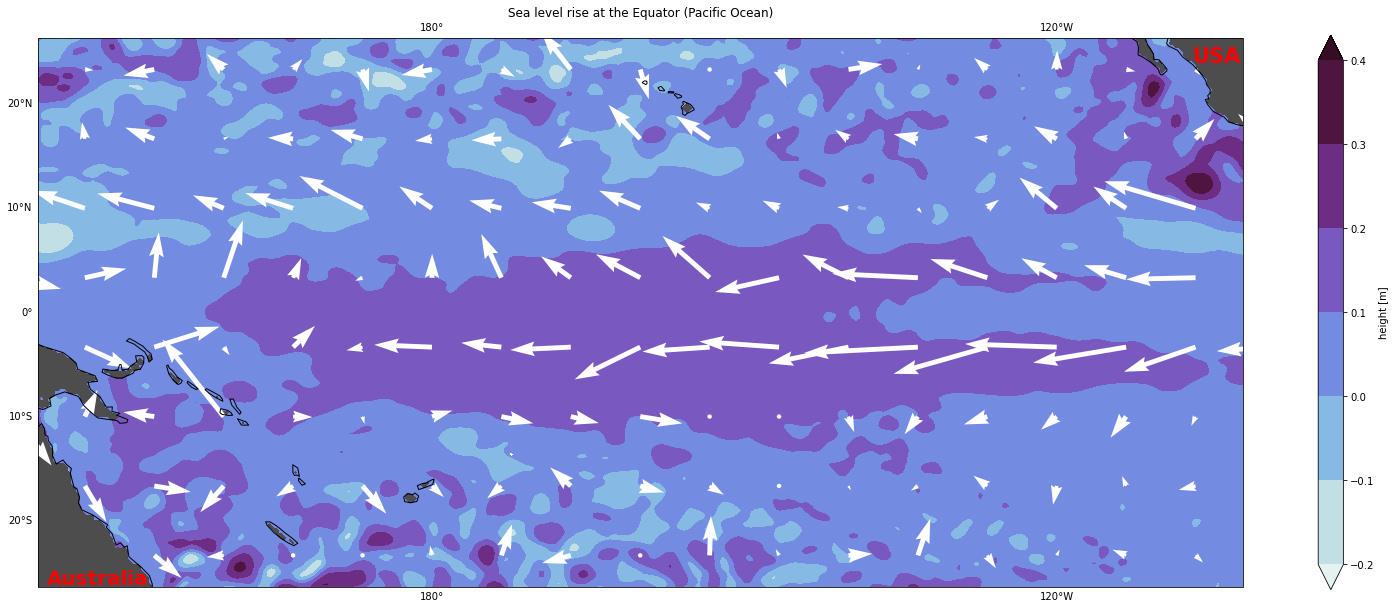

In [199]:
#creating regional boundaries

plt.figure(figsize=(27,12))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines()
ax.set_extent(regional_extent)
cmap=cmo.cm.dense

kw = {
    'level':np.arange(0.3, -0.1),
    'cmap': cmap,
    'extend': 'both',
    'add_colorbar':False
}

im=ax.contourf(ssh.longitude, ssh.latitude,ssh.sla.isel(time=0),transform=ccrs.PlateCarree(),**kw)
plt.colorbar(im, shrink=0.85, label='height [m]')
ax.text(-37,-26.2,'Australia',fontsize=20, fontweight='bold',color='red')
ax.text(73,24,'USA',fontsize=21, fontweight='bold', color='red')
ax.set_title('Sea surface height at the Equator (Pacific Ocean)')
ax.add_feature(cfeature.LAND, facecolor='0.3', edgecolor='black')
gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    alpha=0,
)

# the current direction
skip=20
lon_skipped =  u.longitude[::skip]
lat_skipped = u.latitude[::skip]
kw_vec = {
    'scale': 6
}

u_vel= u.isel(time=0).sel(longitude=lon_skipped, latitude =lat_skipped).values
v_vel = v.isel(time=0).sel(longitude=lon_skipped,latitude =lat_skipped).values
quiver=ax.quiver(lon_skipped, 
           lat_skipped,
           u_vel,
           v_vel,transform=ccrs.PlateCarree(),**kw_vec, color = 'w')

#plt.savefig('SSH_current.png',bbox_inches='tight',dpi=125)